In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import PneumoniaMNIST
from libauc.losses import APLoss, AUCMLoss
from libauc.optimizers import SOAP, PESG
from libauc.models import resnet18
from libauc.metrics import auc_roc_score, auc_prc_score
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Training configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Custom transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
])

# Load datasets
train_dataset = PneumoniaMNIST(split='train', transform=train_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz


In [4]:
# Modify ResNet18 to work with grayscale images
def get_resnet18():
    model = resnet18(num_classes=2)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

In [5]:
# Function to train model and record AUPRC and AUROC
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=100, decay_epochs=[9]):
    train_auprc, test_auprc, train_auroc, test_auroc = [], [], [], []

    for epoch in range(num_epochs):
        if epoch in decay_epochs:
            optimizer.update_regularizer(decay_factor=10)  # Decrease learning rate
            optimizer.lr

        model.train()
        train_loss = []
        for data, targets in train_loader:
            data, targets = data.cuda(), targets.cuda()
            y_pred = model(data)
            y_prob = torch.sigmoid(y_pred)
            loss = loss_fn(y_prob, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        # Evaluation on train set
        train_true, train_pred = [], []
        model.eval()
        with torch.no_grad():
            for data, targets in train_loader:
                data, targets = data.cuda(), targets.cuda()
                y_pred = model(data)
                y_prob = torch.sigmoid(y_pred)
                train_pred.append(y_prob.cpu().detach().numpy())
                train_true.append(targets.cpu().numpy())
        
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        train_auc = auc_roc_score(train_true, train_pred)
        train_ap = auc_prc_score(train_true, train_pred)
        train_auroc.append(train_auc)
        train_auprc.append(train_ap)
        train_loss_ = np.mean(train_loss)
        
        # Evaluation on test set
        test_true, test_pred = [], []
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.cuda(), targets.cuda()
                y_pred = model(data)
                y_prob = torch.sigmoid(y_pred)
                test_pred.append(y_prob.cpu().detach().numpy())
                test_true.append(targets.cpu().numpy())

        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_auc = auc_roc_score(test_true, test_pred)
        test_ap = auc_prc_score(test_true, test_pred)
        test_auroc.append(test_auc)
        test_auprc.append(test_ap)
        
        # Print results for each epoch
        print(epoch, train_loss_, train_auc, test_auc, train_ap, test_ap)
    return train_auprc, test_auprc, train_auroc, test_auroc

In [6]:
# Plotting function
def plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name):
    epochs = range(1, len(train_auprc) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_auprc, label='Train AUPRC')
    plt.plot(epochs, test_auprc, label='Test AUPRC')
    plt.plot(epochs, train_auroc, label='Train AUROC')
    plt.plot(epochs, test_auroc, label='Test AUROC')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title(f'AUPRC and AUROC for {model_name}')
    plt.legend()
    plt.show()

0 0.003712736305739806 [np.float64(0.6881731355894642), 0.0] [np.float64(0.7038899846592155), 0.0] [np.float64(0.8424907891474118), 0.0] [np.float64(0.7693867275527444), 0.0]
1 0.00033167746457636257 [np.float64(0.7446590012155458), 0.0] [np.float64(0.7269669077361385), 0.0] [np.float64(0.8797932327709922), 0.0] [np.float64(0.786703414700415), 0.0]
2 0.00019759387902701524 [np.float64(0.7492512464295111), 0.0] [np.float64(0.7242713127328512), 0.0] [np.float64(0.87886285653261), 0.0] [np.float64(0.784818743061477), 0.0]
3 0.0001497324402727237 [np.float64(0.6965423899195514), 0.0] [np.float64(0.6919241726934034), 0.0] [np.float64(0.8540125413451032), 0.0] [np.float64(0.7626374165931257), 0.0]
4 0.00012035922505625372 [np.float64(0.7178910610705668), 0.0] [np.float64(0.7087771203155819), 0.0] [np.float64(0.860172464525726), 0.0] [np.float64(0.7756741096455197), 0.0]
5 0.00010574840411749933 [np.float64(0.7497911222722125), 0.0] [np.float64(0.7073197457812843), 0.0] [np.float64(0.88091772

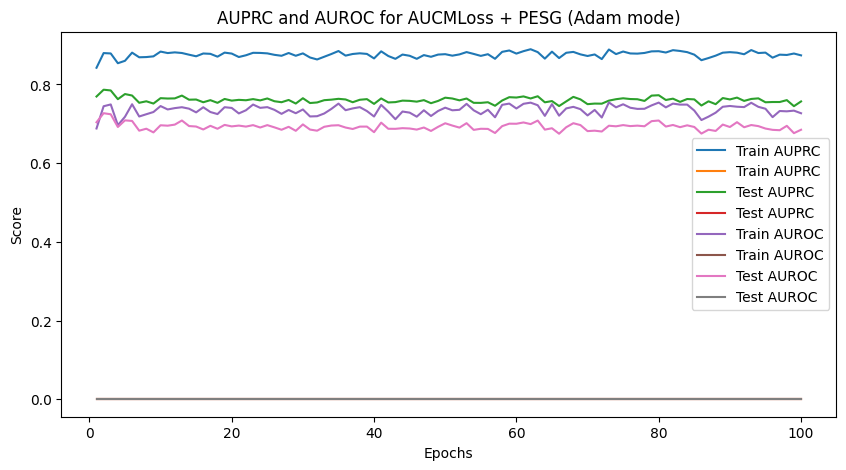

In [7]:
# Configuration 1: APLoss + SOAP (Adam mode)
#model = get_resnet18().to(device)
#loss_fn = APLoss(gamma=0.5)  # Choose gamma from {0.2, 0.5, 0.8}
#optimizer = SOAP(model.parameters(), mode='Adam')
#scheduler = None
#train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
#plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, 'APLoss + SOAP (Adam mode)')

# Configuration 2: AUCMLoss + PESG (Adam mode)
model = get_resnet18().to(device)
scheduler = None
loss_fn = AUCMLoss()
optimizer = PESG(model=model, mode='Adam', lr=0.05)  # Choose lr from {0.02, 0.05, 0.1}
train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, 'AUCMLoss + PESG (Adam mode)')

# Configuration 3: CE Loss + Adam
# model = get_resnet18().to(device)
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Choose lr from {5e-4, 1e-3, 2e-3}
# train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
# plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, 'CE Loss + Adam')